In [22]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import resource
import time
from datetime import datetime
import math
import os
from sklearn import preprocessing
import sys
import cvxpy
from multiprocessing import Process, Pipe
from multiprocessing.pool import ThreadPool

## NOTE: Install keras --------------------------------------------------------------------
###------------------- keras imports for the dataset and neural network --------------------##
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras import optimizers
from keras.layers.normalization import BatchNormalization

%matplotlib inline


In [23]:
image_size = 28
num_features = image_size * image_size
num_classes = 10

num_train = 49000

## Load MNIST Dataset

In [24]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (60000, 28, 28)
Test  data shape: (10000, 28, 28)


## Data Visualization

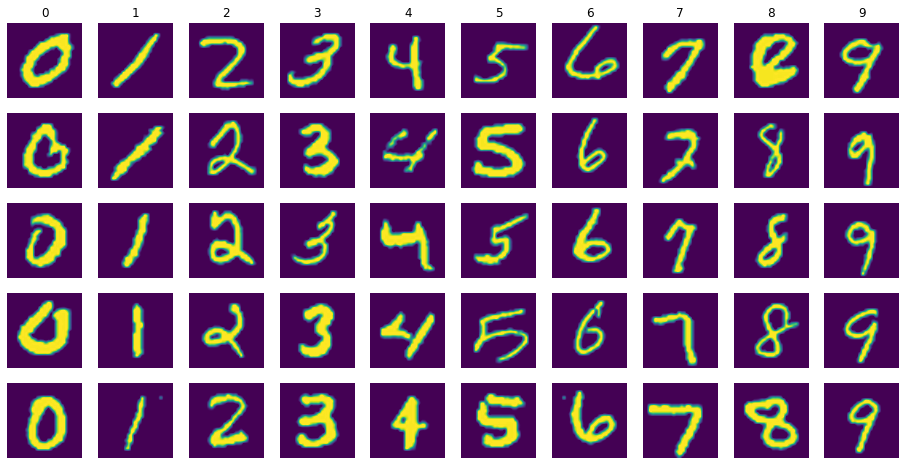

In [25]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
samples_per_class = 5

plt.figure(figsize=(16, 8))

for cls, name in enumerate(class_names):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(samples_per_class, num_classes, i * num_classes + cls + 1)
        plt.imshow(X_train[idx], interpolation='spline16')
        plt.axis('off')
        if i == 0:
            plt.title(class_names[cls])

## Data Preprocessing

In [26]:
# Convert 3D arrays to 2D arrays
X_train =  X_train.reshape([-1, num_features])
X_test  =  X_test.reshape([-1, num_features])

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (60000, 784)
Test  data shape: (10000, 784)


In [27]:
# convert pixel range from [0, 255] to [0., 1.]
X_train = X_train.astype('float32')
x_test  = X_test.astype('float32')

mu = np.mean(X_train, axis=0)

X_train -= mu
X_train /= 255.0

x_test -= mu
x_test /= 255.0

## One-hot encodding
- We have 10 classes: 0, 1, ..., 9

In one-hot encoding, we represent labels using vectors.

```python
0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
.
.
.
9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
```

In [28]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


# Multi-layer Neural Network

### $$f(x) = W_3 \times f(W_2 \times f(0, W_1 x))$$

In [29]:
model = Sequential()

# First hidden Layer
model.add(Dense(units=100, input_shape=(num_features,)))
model.add(Activation(activation='relu'))

# Second hidden Layer
model.add(Dense(units=100))
model.add(Activation(activation='relu'))

# Third hidden Layer
model.add(Dense(units=100, input_shape=(num_features,)))
model.add(Activation(activation='relu'))


# Output Layer
model.add(Dense(units=num_classes, activation='softmax'))

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_6 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

## Training the model with SGD

In [31]:
optimizer = keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
start = time.time()
history = model.fit(X_train[:num_train], y_train[:num_train], 
                    batch_size=None, 
                    epochs=30,
                    verbose=2,
                    validation_data=(X_train[num_train:], y_train[num_train:]),
                    shuffle=True)
end = time.time()
print("Time duration:",end-start)

Train on 49000 samples, validate on 11000 samples
Epoch 1/30
 - 3s - loss: 2.2258 - accuracy: 0.2367 - val_loss: 2.1104 - val_accuracy: 0.3712
Epoch 2/30
 - 3s - loss: 1.9270 - accuracy: 0.4806 - val_loss: 1.7073 - val_accuracy: 0.6006
Epoch 3/30
 - 3s - loss: 1.4622 - accuracy: 0.6553 - val_loss: 1.1964 - val_accuracy: 0.7359
Epoch 4/30
 - 3s - loss: 1.0090 - accuracy: 0.7680 - val_loss: 0.8076 - val_accuracy: 0.8251
Epoch 5/30
 - 3s - loss: 0.7210 - accuracy: 0.8260 - val_loss: 0.6013 - val_accuracy: 0.8567
Epoch 6/30
 - 3s - loss: 0.5694 - accuracy: 0.8535 - val_loss: 0.4939 - val_accuracy: 0.8728
Epoch 7/30
 - 3s - loss: 0.4841 - accuracy: 0.8696 - val_loss: 0.4313 - val_accuracy: 0.8828
Epoch 8/30
 - 3s - loss: 0.4304 - accuracy: 0.8799 - val_loss: 0.3899 - val_accuracy: 0.8916
Epoch 9/30
 - 3s - loss: 0.3934 - accuracy: 0.8888 - val_loss: 0.3608 - val_accuracy: 0.8980
Epoch 10/30
 - 3s - loss: 0.3659 - accuracy: 0.8950 - val_loss: 0.3388 - val_accuracy: 0.9026
Epoch 11/30
 - 3s -

In [33]:
#model.save('Multi_layer_NN_Model.CA7')

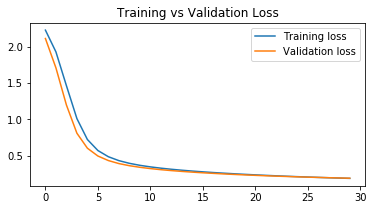

In [34]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

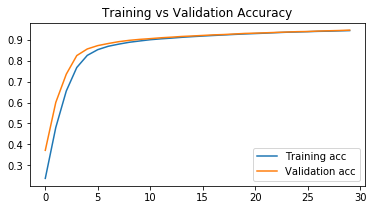

In [35]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

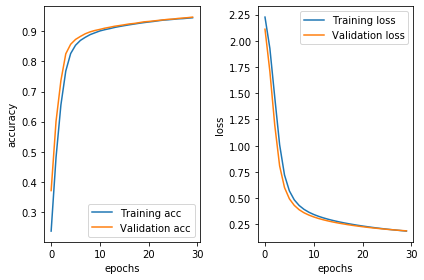

In [36]:
f, axs = plt.subplots(1,2)
axs[0].plot(history.history['accuracy'], label="Training acc")
axs[0].plot(history.history['val_accuracy'], label="Validation acc")
axs[0].legend()
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
#axs[0].set_ylim([0.9465, 0.9485])
axs[1].plot(history.history['loss'], label="Training loss")
axs[1].plot(history.history['val_loss'], label="Validation loss")
axs[1].legend()
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
#axs[1].set_ylim([0, 2.25])
plt.tight_layout()

In [37]:
# Select 25 random images from test images
idx = np.random.choice(X_test.shape[0], 25, replace=False)

# predict class for selected images
y_pred = model.predict_classes(X_test[idx])

# True class for selected images
y_true = y_test[idx].argmax(axis=1)

print('Test Accuracy = %.2f' % (100.0 * np.mean(y_pred == y_true)))

Test Accuracy = 88.00


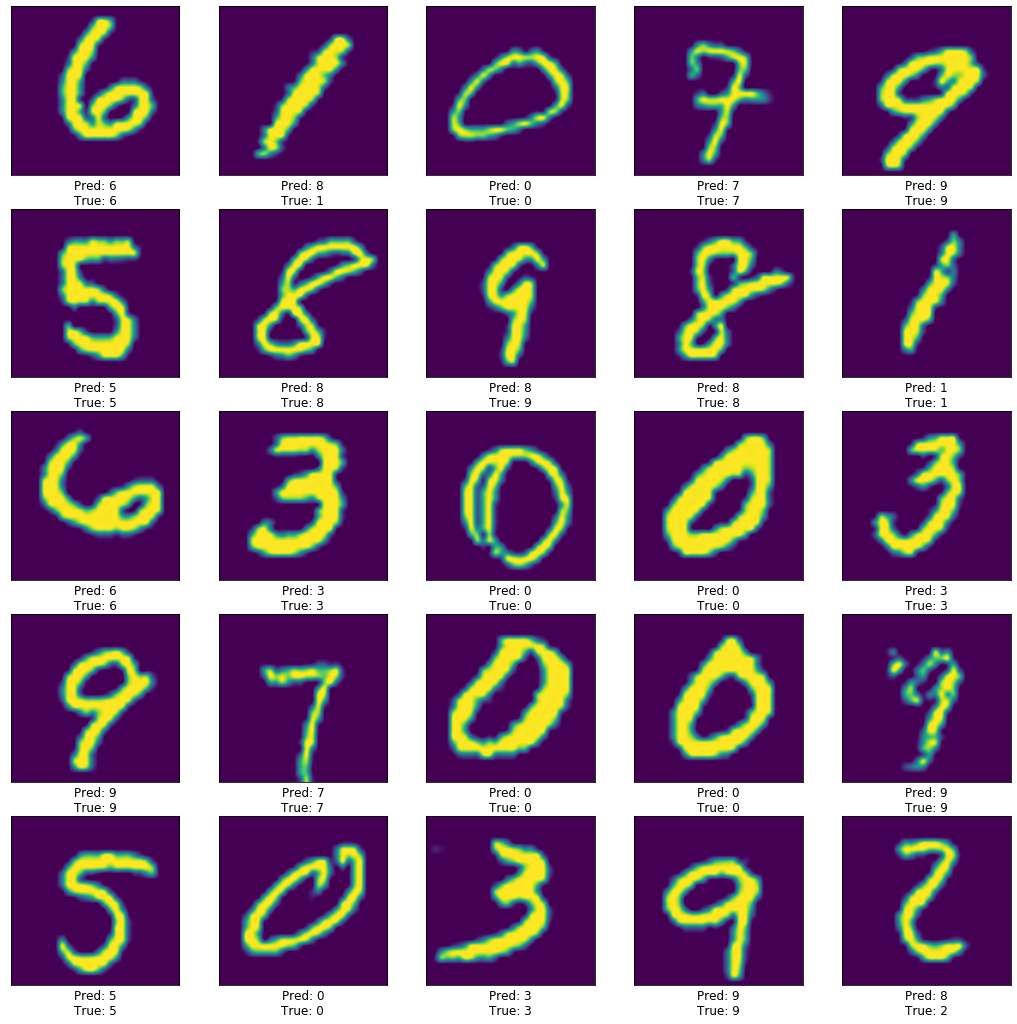

In [38]:
fig, axes = plt.subplots(5, 5, figsize=(18, 18))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[idx[i]].reshape(image_size, image_size), interpolation='spline16')
    pred_class = class_names[y_pred[i]]
    true_class = class_names[y_true[i]]
    ax.set_xlabel('Pred: {}\nTrue: {}'.format(pred_class, true_class), fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

## Training the model with ADAM

In [39]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
start = time.time()
history = model.fit(X_train[:num_train], y_train[:num_train], 
                    batch_size=None, 
                    epochs=30,
                    verbose=2,
                    validation_data=(X_train[num_train:], y_train[num_train:]),
                    shuffle=True)
end = time.time()
print("Time duration:",end-start)

Train on 49000 samples, validate on 11000 samples
Epoch 1/30
 - 4s - loss: 0.1595 - accuracy: 0.9514 - val_loss: 0.1126 - val_accuracy: 0.9664
Epoch 2/30
 - 4s - loss: 0.0856 - accuracy: 0.9733 - val_loss: 0.1084 - val_accuracy: 0.9688
Epoch 3/30
 - 3s - loss: 0.0632 - accuracy: 0.9793 - val_loss: 0.0985 - val_accuracy: 0.9727
Epoch 4/30
 - 4s - loss: 0.0459 - accuracy: 0.9852 - val_loss: 0.1007 - val_accuracy: 0.9740
Epoch 5/30
 - 4s - loss: 0.0415 - accuracy: 0.9859 - val_loss: 0.1051 - val_accuracy: 0.9725
Epoch 6/30
 - 4s - loss: 0.0336 - accuracy: 0.9890 - val_loss: 0.1076 - val_accuracy: 0.9720
Epoch 7/30
 - 4s - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.1312 - val_accuracy: 0.9704
Epoch 8/30
 - 3s - loss: 0.0287 - accuracy: 0.9909 - val_loss: 0.1134 - val_accuracy: 0.9727
Epoch 9/30
 - 4s - loss: 0.0218 - accuracy: 0.9928 - val_loss: 0.1384 - val_accuracy: 0.9709
Epoch 10/30
 - 3s - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.1218 - val_accuracy: 0.9728
Epoch 11/30
 - 4s -

In [41]:
#model.save('Multi_layer_NN_Model.CA7')

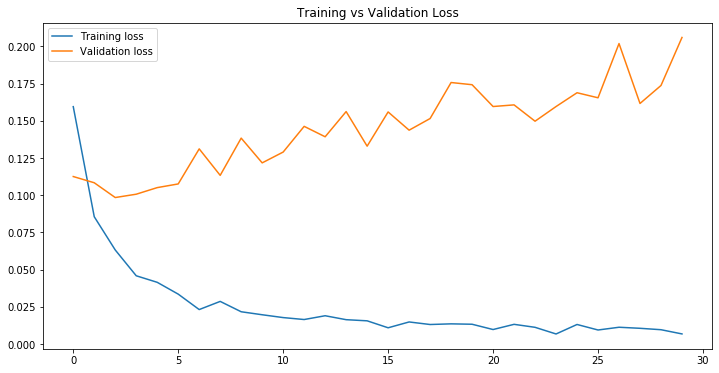

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

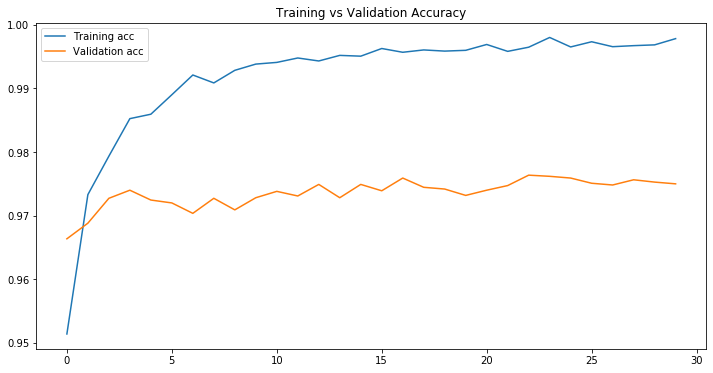

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

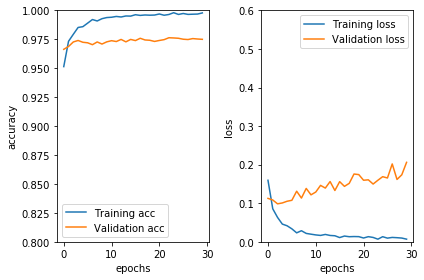

In [57]:
f, axs = plt.subplots(1,2)
axs[0].plot(history.history['accuracy'], label="Training acc")
axs[0].plot(history.history['val_accuracy'], label="Validation acc")
axs[0].legend()
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].set_ylim([0.8, 1])
axs[1].plot(history.history['loss'], label="Training loss")
axs[1].plot(history.history['val_loss'], label="Validation loss")
axs[1].legend()
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].set_ylim([0, 0.6])
plt.tight_layout()

In [58]:
# Select 25 random images from test images
idx = np.random.choice(X_test.shape[0], 25, replace=False)

# predict class for selected images
y_pred = model.predict_classes(X_test[idx])

# True class for selected images
y_true = y_test[idx].argmax(axis=1)

print('Test Accuracy = %.2f' % (100.0 * np.mean(y_pred == y_true)))

Test Accuracy = 92.00


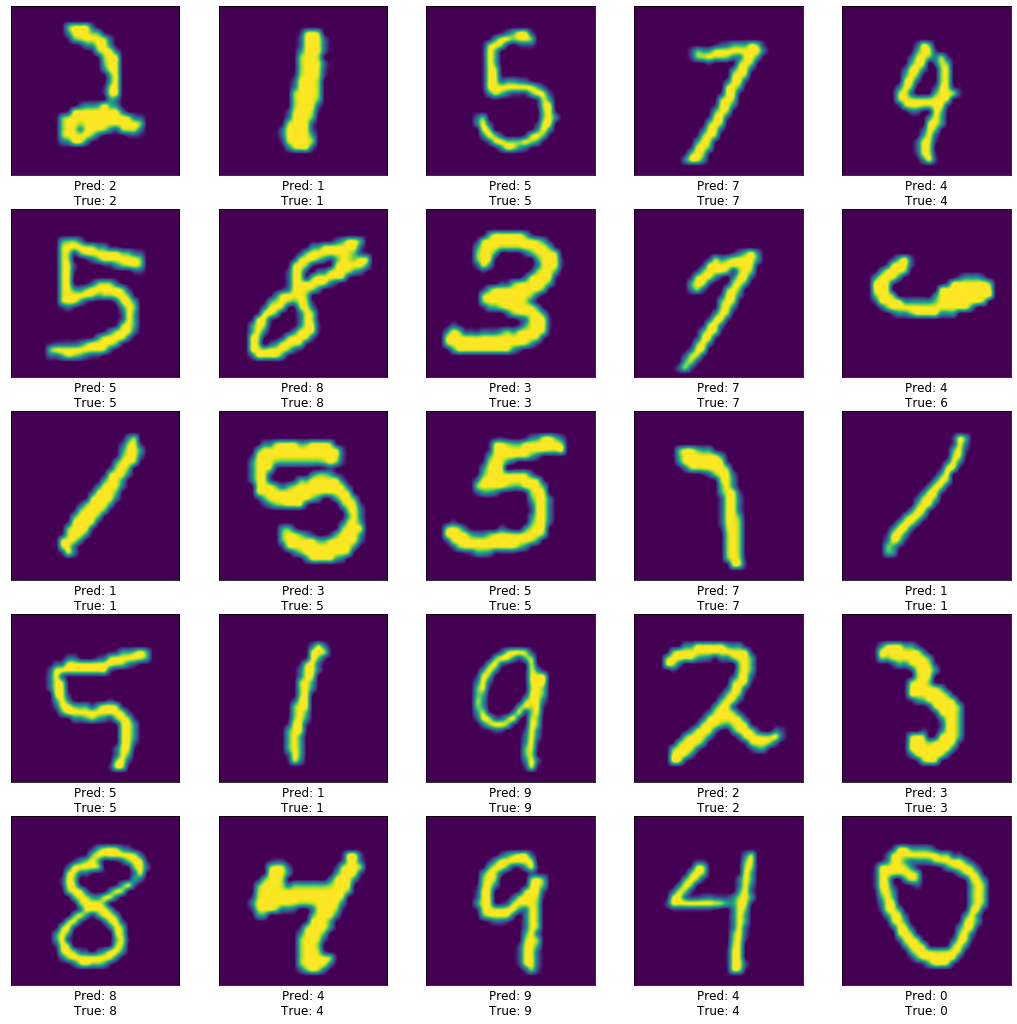

In [59]:
fig, axes = plt.subplots(5, 5, figsize=(18, 18))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[idx[i]].reshape(image_size, image_size), interpolation='spline16')
    pred_class = class_names[y_pred[i]]
    true_class = class_names[y_true[i]]
    ax.set_xlabel('Pred: {}\nTrue: {}'.format(pred_class, true_class), fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])